# Análises

Este notebook tem como principal objetivo analisar a presença de pessoas diversas dentro da empresa fictícia e pontuar os cargos e departamentos em que há mais espaço para inclusão. Ajudando o departamento de Recursos Humanos a direcionar treinamentos e vagas inclusivas.

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [155]:
dados_funcionarios = pd.read_csv('dados/resultados/dados_funcionarios_final.csv', sep=";", decimal=",")

### Índice de Diversidade por Cargo e Departamento
Identifica se há pessoas de todos os grupos em todos os departamentos - e lea em consideração o tamanho o departamento

In [156]:
# Definindo valores que serão desconsiderados no índice
categorias_excluir = ["Outro", "Prefere Não Informar", "Não Declarada"]
df_limpo = dados_funcionarios.copy()
variaveis = [
    'Gênero Social', # ['Mulher', 'Homem', 'Prefere Não Informar', 'Não Binário', 'Outro']
    'Identidade Gênero', # ['Transgênero', 'Cisgênero', 'Prefere Não Informar', 'Outro']
    'Etnia Minoria', # ['Branca/Amarela', 'Preta/Parda/Indígena', 'Não Declarada']
    'Orientação Sexual Minoria', # ['Heterossexual', 'Prefere Não Informar', 'Não Heterossexual'
    'PCD', # ['Sim', 'Não', 'Prefere Não Informar']
    'Faixa Etária' # ['50-', '50+']
]

for v in variaveis:
    df_limpo.loc[df_limpo[v].isin(categorias_excluir), v] = None

grupos_possiveis = {
    v: len(df_limpo[v].dropna().unique())
    for v in variaveis
}

total_possivel = sum(grupos_possiveis.values())

In [157]:
# Contagem por Dep/Cargo
diversidade_dep_cargo = df_limpo.groupby(["Departamento", "Cargo"], as_index=False).agg({
    **{v: lambda x: x.dropna().nunique() for v in variaveis},
    "Id": "count"
})

diversidade_dep_cargo.rename(columns={"Id": "total_pessoas"}, inplace=True)

# Total de grupos observados por Dep/Cargo
diversidade_dep_cargo["N_grupos_dep"] = diversidade_dep_cargo[variaveis].sum(axis=1)

# Limite máximo de diversidade para o tamanho do grupo
diversidade_dep_cargo["Max_diversidade_tamanho"] = diversidade_dep_cargo["total_pessoas"].clip(upper=total_possivel)

# Diversidade observada
diversidade_dep_cargo["Div_Observada"] = ( diversidade_dep_cargo["N_grupos_dep"] / diversidade_dep_cargo["Max_diversidade_tamanho"])

In [158]:
diversidade_dep_cargo

,Departamento,Cargo,Gênero Social,Identidade Gênero,Etnia Minoria,Orientação Sexual Minoria,PCD,Faixa Etária,total_pessoas,N_grupos_dep,Max_diversidade_tamanho,Div_Observada
0,Financeiro,Gerente,3,2,2,2,2,2,140,13,13,1.000000
1,Financeiro,Subordinado,3,2,2,2,2,2,1289,13,13,1.000000
2,Marketing,Gerente,3,2,2,2,2,2,129,13,13,1.000000
3,Marketing,Subordinado,3,2,2,2,2,2,1211,13,13,1.000000
4,Operações,Gerente,3,2,2,2,2,2,131,13,13,1.000000
5,Operações,Subordinado,3,2,2,2,2,2,1096,13,13,1.000000
6,Pesquisa e Desenvolvimento,Gerente,3,1,2,2,2,2,36,12,13,0.923077
7,Pesquisa e Desenvolvimento,Subordinado,3,2,2,2,2,2,427,13,13,1.000000
8,Recursos Humanos,Gerente,3,1,2,2,2,2,97,12,13,0.923077
9,Recursos Humanos,Subordinado,3,2,2,2,2,2,893,13,13,1.000000


In [159]:
# Parametro que define o quanto um grupo será penalizado por não possuir algum grupo
# Quanto maior o grupo e menor o número de grupos presentes, menor o índice
# Esse índice leva em consideração se existe pelo menos 1 pessoa de cada grupo no departamento + cargo 
alpha = 3.0

n_max = diversidade_dep_cargo["total_pessoas"].max()
n_min = diversidade_dep_cargo["total_pessoas"].min()

# evitar divisão por zero se n_max == 1
den = (n_max - 1) if (n_max - 1) > 0 else 1

# gamma que cresce com o tamanho
diversidade_dep_cargo["gamma"] = 1 + alpha * ((diversidade_dep_cargo["total_pessoas"] - 1) / den)

# índice final aplicando a potência
diversidade_dep_cargo["Índice de Diversidade"] = round(diversidade_dep_cargo["Div_Observada"] ** diversidade_dep_cargo["gamma"], 4)

In [160]:
diversidade_dep_cargo

,Departamento,Cargo,Gênero Social,Identidade Gênero,Etnia Minoria,Orientação Sexual Minoria,PCD,Faixa Etária,total_pessoas,N_grupos_dep,Max_diversidade_tamanho,Div_Observada,gamma,Índice de Diversidade
0,Financeiro,Gerente,3,2,2,2,2,2,140,13,13,1.000000,1.202035,1.0000
1,Financeiro,Subordinado,3,2,2,2,2,2,1289,13,13,1.000000,2.872093,1.0000
2,Marketing,Gerente,3,2,2,2,2,2,129,13,13,1.000000,1.186047,1.0000
3,Marketing,Subordinado,3,2,2,2,2,2,1211,13,13,1.000000,2.758721,1.0000
4,Operações,Gerente,3,2,2,2,2,2,131,13,13,1.000000,1.188953,1.0000
5,Operações,Subordinado,3,2,2,2,2,2,1096,13,13,1.000000,2.591570,1.0000
6,Pesquisa e Desenvolvimento,Gerente,3,1,2,2,2,2,36,12,13,0.923077,1.050872,0.9193
7,Pesquisa e Desenvolvimento,Subordinado,3,2,2,2,2,2,427,13,13,1.000000,1.619186,1.0000
8,Recursos Humanos,Gerente,3,1,2,2,2,2,97,12,13,0.923077,1.139535,0.9128
9,Recursos Humanos,Subordinado,3,2,2,2,2,2,893,13,13,1.000000,2.296512,1.0000


In [161]:
diversidade_dep_cargo.loc[diversidade_dep_cargo['Cargo']=='Gerente']

,Departamento,Cargo,Gênero Social,Identidade Gênero,Etnia Minoria,Orientação Sexual Minoria,PCD,Faixa Etária,total_pessoas,N_grupos_dep,Max_diversidade_tamanho,Div_Observada,gamma,Índice de Diversidade
0,Financeiro,Gerente,3,2,2,2,2,2,140,13,13,1.000000,1.202035,1.0000
2,Marketing,Gerente,3,2,2,2,2,2,129,13,13,1.000000,1.186047,1.0000
4,Operações,Gerente,3,2,2,2,2,2,131,13,13,1.000000,1.188953,1.0000
6,Pesquisa e Desenvolvimento,Gerente,3,1,2,2,2,2,36,12,13,0.923077,1.050872,0.9193
8,Recursos Humanos,Gerente,3,1,2,2,2,2,97,12,13,0.923077,1.139535,0.9128
10,TI,Gerente,2,1,2,2,2,2,241,11,13,0.846154,1.348837,0.7983
12,Vendas,Gerente,3,1,2,2,2,2,207,12,13,0.923077,1.299419,0.9012


### Comparativo com cota

In [162]:
# tabela com o total geral de número  
tabela_funcionarios = dados_funcionarios.groupby(["Departamento", "Cargo"], as_index=False).agg({"Id": "count"})
tabela_funcionarios = tabela_funcionarios.rename(columns={'Id': 'total_pessoas'})

#### Gênero Social

In [163]:
cota_mulher = 0.4

In [164]:
tabela_genero_social = dados_funcionarios.pivot_table(
        index=["Departamento", "Cargo"],
        columns="Gênero Social",
        values="Id",
        aggfunc="count",
        fill_value=0
).reset_index()

tabela_genero_social = tabela_genero_social.merge(tabela_funcionarios, on=["Departamento", "Cargo"], how="left")
tabela_genero_social

,Departamento,Cargo,Homem,Mulher,Não Binário,Outro,Prefere Não Informar,total_pessoas
0,Financeiro,Gerente,81,50,1,2,6,140
1,Financeiro,Subordinado,772,427,14,15,61,1289
2,Marketing,Gerente,69,48,2,2,8,129
3,Marketing,Subordinado,722,421,9,13,46,1211
4,Operações,Gerente,74,46,3,1,7,131
5,Operações,Subordinado,656,361,13,13,53,1096
6,Pesquisa e Desenvolvimento,Gerente,19,15,1,1,0,36
7,Pesquisa e Desenvolvimento,Subordinado,246,159,3,4,15,427
8,Recursos Humanos,Gerente,54,36,1,2,4,97
9,Recursos Humanos,Subordinado,539,306,8,12,28,893


In [165]:
# Calculando o percentual

tabela_mulher = tabela_genero_social[['Cargo', 'Departamento', 'Mulher', 'total_pessoas']].copy()
tabela_mulher['Mulher (%)'] = round(tabela_mulher['Mulher']/tabela_mulher['total_pessoas'], 4) # Porcentagem Atual
tabela_mulher['Cota Mulher (%)']= cota_mulher # Percentual mínimo de mulheres desejado
tabela_mulher['Diferença Percentual'] = tabela_mulher['Cota Mulher (%)'] - tabela_mulher['Mulher (%)'] # Quanto falta para alcançar a cota / quanto já alcançou
tabela_mulher['Cota Mulher (qtd)'] = round(tabela_mulher['total_pessoas']*cota_mulher) # Quantas mulheres deveria ter no cargo departamento
tabela_mulher['Espaço de Contratação'] = tabela_mulher['Cota Mulher (qtd)'] - tabela_mulher['Mulher'] # Quantas Mulheres faltam para bater a cota

# Classificando do cargo e departamento com maior diferença percentual entre a cota e o real
tabela_mulher.sort_values('Diferença Percentual', ascending=False)

,Cargo,Departamento,Mulher,total_pessoas,Mulher (%),Cota Mulher (%),Diferença Percentual,Cota Mulher (qtd),Espaço de Contratação
5,Subordinado,Operações,361,1096,0.3294,0.4,0.0706,438.0,77.0
1,Subordinado,Financeiro,427,1289,0.3313,0.4,0.0687,516.0,89.0
11,Subordinado,TI,694,2065,0.3361,0.4,0.0639,826.0,132.0
9,Subordinado,Recursos Humanos,306,893,0.3427,0.4,0.0573,357.0,51.0
3,Subordinado,Marketing,421,1211,0.3476,0.4,0.0524,484.0,63.0
13,Subordinado,Vendas,710,2038,0.3484,0.4,0.0516,815.0,105.0
10,Gerente,TI,84,241,0.3485,0.4,0.0515,96.0,12.0
4,Gerente,Operações,46,131,0.3511,0.4,0.0489,52.0,6.0
0,Gerente,Financeiro,50,140,0.3571,0.4,0.0429,56.0,6.0
12,Gerente,Vendas,74,207,0.3575,0.4,0.0425,83.0,9.0


#### Identidade de Gênero

In [166]:
cota_trans = 0.05

In [167]:
tabela_identidade_genero = dados_funcionarios.pivot_table(
        index=["Departamento", "Cargo"],
        columns="Identidade Gênero",
        values="Id",
        aggfunc="count",
        fill_value=0
).reset_index()

tabela_identidade_genero = tabela_identidade_genero.merge(tabela_funcionarios, on=["Departamento", "Cargo"], how="left")
tabela_identidade_genero

,Departamento,Cargo,Cisgênero,Outro,Prefere Não Informar,Transgênero,total_pessoas
0,Financeiro,Gerente,128,3,6,3,140
1,Financeiro,Subordinado,1190,29,61,9,1289
2,Marketing,Gerente,116,4,8,1,129
3,Marketing,Subordinado,1130,22,46,13,1211
4,Operações,Gerente,118,4,7,2,131
5,Operações,Subordinado,1008,26,53,9,1096
6,Pesquisa e Desenvolvimento,Gerente,34,2,0,0,36
7,Pesquisa e Desenvolvimento,Subordinado,398,7,15,7,427
8,Recursos Humanos,Gerente,90,3,4,0,97
9,Recursos Humanos,Subordinado,832,20,28,13,893


In [168]:
# Calculando o percentual

tabela_trans = tabela_identidade_genero[['Cargo', 'Departamento', 'Transgênero', 'total_pessoas']].copy()
tabela_trans['Transgênero (%)'] = round(tabela_trans['Transgênero']/tabela_trans['total_pessoas'], 4)
tabela_trans['Cota Transgênero (%)']= cota_trans
tabela_trans['Diferença Percentual'] = tabela_trans['Cota Transgênero (%)'] - tabela_trans['Transgênero (%)']
tabela_trans['Cota Transgênero (qtd)'] = round(tabela_trans['total_pessoas']*cota_trans)
tabela_trans['Espaço de Contratação'] = tabela_trans['Cota Transgênero (qtd)'] - tabela_trans['Transgênero']

# Classificando do cargo e departamento com maior diferença percentual entre a cota e o real
tabela_trans.sort_values('Diferença Percentual', ascending=False)

,Cargo,Departamento,Transgênero,total_pessoas,Transgênero (%),Cota Transgênero (%),Diferença Percentual,Cota Transgênero (qtd),Espaço de Contratação
8,Gerente,Recursos Humanos,0,97,0.0000,0.05,0.0500,5.0,5.0
6,Gerente,Pesquisa e Desenvolvimento,0,36,0.0000,0.05,0.0500,2.0,2.0
10,Gerente,TI,0,241,0.0000,0.05,0.0500,12.0,12.0
12,Gerente,Vendas,0,207,0.0000,0.05,0.0500,10.0,10.0
1,Subordinado,Financeiro,9,1289,0.0070,0.05,0.0430,64.0,55.0
2,Gerente,Marketing,1,129,0.0078,0.05,0.0422,6.0,5.0
5,Subordinado,Operações,9,1096,0.0082,0.05,0.0418,55.0,46.0
13,Subordinado,Vendas,17,2038,0.0083,0.05,0.0417,102.0,85.0
3,Subordinado,Marketing,13,1211,0.0107,0.05,0.0393,61.0,48.0
11,Subordinado,TI,23,2065,0.0111,0.05,0.0389,103.0,80.0


#### Etnia

In [169]:
cota_ppi = 0.4


In [170]:
tabela_etnia = dados_funcionarios.pivot_table(
        index=["Departamento", "Cargo"],
        columns="Etnia Minoria",
        values="Id",
        aggfunc="count",
        fill_value=0
).reset_index()

tabela_etnia = tabela_etnia.merge(tabela_funcionarios, on=["Departamento", "Cargo"], how="left")
tabela_etnia

,Departamento,Cargo,Branca/Amarela,Não Declarada,Preta/Parda/Indígena,total_pessoas
0,Financeiro,Gerente,95,4,41,140
1,Financeiro,Subordinado,964,29,296,1289
2,Marketing,Gerente,99,2,28,129
3,Marketing,Subordinado,881,33,297,1211
4,Operações,Gerente,100,5,26,131
5,Operações,Subordinado,829,29,238,1096
6,Pesquisa e Desenvolvimento,Gerente,32,0,4,36
7,Pesquisa e Desenvolvimento,Subordinado,326,11,90,427
8,Recursos Humanos,Gerente,74,2,21,97
9,Recursos Humanos,Subordinado,658,10,225,893


In [171]:
# Calculando o percentual

tabela_ppi = tabela_etnia[['Cargo', 'Departamento', 'Preta/Parda/Indígena', 'total_pessoas']].copy()
tabela_ppi['PPI (%)'] = round(tabela_ppi['Preta/Parda/Indígena']/tabela_ppi['total_pessoas'], 4) # Porcentagem Atual
tabela_ppi['Cota PPI (%)']= cota_ppi # Percentual mínimo de mulheres desejado
tabela_ppi['Diferença Percentual'] = tabela_ppi['Cota PPI (%)'] - tabela_ppi['PPI (%)'] # Quanto falta para alcançar a cota / quanto já alcançou
tabela_ppi['Cota PPI (qtd)'] = round(tabela_ppi['total_pessoas']*cota_ppi) # Quantas mulheres deveria ter no cargo departamento
tabela_ppi['Espaço de Contratação'] = tabela_ppi['Cota PPI (qtd)'] - tabela_ppi['Preta/Parda/Indígena'] # Quantas Mulheres faltam para bater a cota

# Classificando do cargo e departamento com maior diferença percentual entre a cota e o real
tabela_ppi.sort_values('Diferença Percentual', ascending=False)

,Cargo,Departamento,Preta/Parda/Indígena,total_pessoas,PPI (%),Cota PPI (%),Diferença Percentual,Cota PPI (qtd),Espaço de Contratação
6,Gerente,Pesquisa e Desenvolvimento,4,36,0.1111,0.4,0.2889,14.0,10.0
4,Gerente,Operações,26,131,0.1985,0.4,0.2015,52.0,26.0
7,Subordinado,Pesquisa e Desenvolvimento,90,427,0.2108,0.4,0.1892,171.0,81.0
8,Gerente,Recursos Humanos,21,97,0.2165,0.4,0.1835,39.0,18.0
2,Gerente,Marketing,28,129,0.2171,0.4,0.1829,52.0,24.0
5,Subordinado,Operações,238,1096,0.2172,0.4,0.1828,438.0,200.0
13,Subordinado,Vendas,445,2038,0.2184,0.4,0.1816,815.0,370.0
1,Subordinado,Financeiro,296,1289,0.2296,0.4,0.1704,516.0,220.0
11,Subordinado,TI,487,2065,0.2358,0.4,0.1642,826.0,339.0
10,Gerente,TI,59,241,0.2448,0.4,0.1552,96.0,37.0


#### PCD

In [172]:
cota_pcd = 0.5

In [173]:
tabela_pcd = dados_funcionarios.pivot_table(
        index=["Departamento", "Cargo"],
        columns="PCD",
        values="Id",
        aggfunc="count",
        fill_value=0
).reset_index()

tabela_pcd = tabela_pcd.merge(tabela_funcionarios, on=["Departamento", "Cargo"], how="left")
tabela_pcd

,Departamento,Cargo,Não,Prefere Não Informar,Sim,total_pessoas
0,Financeiro,Gerente,118,2,20,140
1,Financeiro,Subordinado,1060,43,186,1289
2,Marketing,Gerente,108,2,19,129
3,Marketing,Subordinado,1007,33,171,1211
4,Operações,Gerente,108,5,18,131
5,Operações,Subordinado,892,31,173,1096
6,Pesquisa e Desenvolvimento,Gerente,34,0,2,36
7,Pesquisa e Desenvolvimento,Subordinado,357,15,55,427
8,Recursos Humanos,Gerente,79,3,15,97
9,Recursos Humanos,Subordinado,729,26,138,893


In [174]:
# Calculando o percentual
tabela_ehpcd = tabela_pcd[['Cargo', 'Departamento', 'Sim', 'total_pessoas']].copy()
tabela_ehpcd['PCD (%)'] = round(tabela_ehpcd['Sim']/tabela_ehpcd['total_pessoas'], 4)
tabela_ehpcd['Cota PCD (%)']= cota_pcd
tabela_ehpcd['Diferença Percentual'] = tabela_ehpcd['Cota PCD (%)'] - tabela_ehpcd['PCD (%)']
tabela_ehpcd['Cota PCD (qtd)'] = round(tabela_ehpcd['total_pessoas']*cota_pcd)
tabela_ehpcd['Espaço de Contratação'] = tabela_ehpcd['Cota PCD (qtd)'] - tabela_ehpcd['Sim']

# Classificando do cargo e departamento com maior diferença percentual entre a cota e o real
tabela_ehpcd.sort_values('Diferença Percentual', ascending=False)

,Cargo,Departamento,Sim,total_pessoas,PCD (%),Cota PCD (%),Diferença Percentual,Cota PCD (qtd),Espaço de Contratação
6,Gerente,Pesquisa e Desenvolvimento,2,36,0.0556,0.5,0.4444,18.0,16.0
7,Subordinado,Pesquisa e Desenvolvimento,55,427,0.1288,0.5,0.3712,214.0,159.0
12,Gerente,Vendas,28,207,0.1353,0.5,0.3647,104.0,76.0
4,Gerente,Operações,18,131,0.1374,0.5,0.3626,66.0,48.0
3,Subordinado,Marketing,171,1211,0.1412,0.5,0.3588,606.0,435.0
0,Gerente,Financeiro,20,140,0.1429,0.5,0.3571,70.0,50.0
1,Subordinado,Financeiro,186,1289,0.1443,0.5,0.3557,644.0,458.0
2,Gerente,Marketing,19,129,0.1473,0.5,0.3527,64.0,45.0
10,Gerente,TI,37,241,0.1535,0.5,0.3465,120.0,83.0
9,Subordinado,Recursos Humanos,138,893,0.1545,0.5,0.3455,446.0,308.0


#### Faixa Etária

In [175]:
cota_50mais = 0.1

In [176]:
# Total de pessoas por identidade de gênero
tabela_etariedade = dados_funcionarios.pivot_table(
        index=["Departamento", "Cargo"],
        columns="Faixa Etária",
        values="Id",
        aggfunc="count",
        fill_value=0
).reset_index()

tabela_etariedade = tabela_etariedade.merge(tabela_funcionarios, on=["Departamento", "Cargo"], how="left")
tabela_etariedade

,Departamento,Cargo,50+,50-,total_pessoas
0,Financeiro,Gerente,27,113,140
1,Financeiro,Subordinado,185,1104,1289
2,Marketing,Gerente,23,106,129
3,Marketing,Subordinado,183,1028,1211
4,Operações,Gerente,24,107,131
5,Operações,Subordinado,172,924,1096
6,Pesquisa e Desenvolvimento,Gerente,3,33,36
7,Pesquisa e Desenvolvimento,Subordinado,65,362,427
8,Recursos Humanos,Gerente,11,86,97
9,Recursos Humanos,Subordinado,148,745,893


In [177]:
# Calculando o percentual

tabela_50mais = tabela_etariedade[['Cargo', 'Departamento', '50+', 'total_pessoas']].copy()
tabela_50mais['50 mais (%)'] = round(tabela_50mais['50+']/tabela_50mais['total_pessoas'], 4) # Porcentagem Atual
tabela_50mais['Cota 50 mais (%)']= cota_50mais # Percentual mínimo de mulheres desejado
tabela_50mais['Diferença Percentual'] = tabela_50mais['Cota 50 mais (%)'] - tabela_50mais['50 mais (%)'] # Quanto falta para alcançar a cota / quanto já alcançou
tabela_50mais['Cota 50 mais (qtd)'] = round(tabela_50mais['total_pessoas']*cota_50mais) # Quantas mulheres deveria ter no cargo departamento
tabela_50mais['Espaço de Contratação'] = tabela_50mais['Cota 50 mais (qtd)'] - tabela_50mais['50+'] # Quantas Mulheres faltam para bater a cota

# Classificando do cargo e departamento com maior diferença percentual entre a cota e o real
tabela_50mais.sort_values('Diferença Percentual', ascending=False)

,Cargo,Departamento,50+,total_pessoas,50 mais (%),Cota 50 mais (%),Diferença Percentual,Cota 50 mais (qtd),Espaço de Contratação
6,Gerente,Pesquisa e Desenvolvimento,3,36,0.0833,0.1,0.0167,4.0,1.0
8,Gerente,Recursos Humanos,11,97,0.1134,0.1,-0.0134,10.0,-1.0
12,Gerente,Vendas,27,207,0.1304,0.1,-0.0304,21.0,-6.0
1,Subordinado,Financeiro,185,1289,0.1435,0.1,-0.0435,129.0,-56.0
3,Subordinado,Marketing,183,1211,0.1511,0.1,-0.0511,121.0,-62.0
7,Subordinado,Pesquisa e Desenvolvimento,65,427,0.1522,0.1,-0.0522,43.0,-22.0
13,Subordinado,Vendas,314,2038,0.1541,0.1,-0.0541,204.0,-110.0
5,Subordinado,Operações,172,1096,0.1569,0.1,-0.0569,110.0,-62.0
11,Subordinado,TI,335,2065,0.1622,0.1,-0.0622,206.0,-129.0
9,Subordinado,Recursos Humanos,148,893,0.1657,0.1,-0.0657,89.0,-59.0


### Testes T - Desigualdade Salarial

In [178]:
def testesT_dep_cargo(dados, col_valor, col_grupo, valor_ref, valor_min):
    resultados = []

    grupos = dados.groupby(['Cargo', 'Departamento'])

    nivel_confianca = 0.95
    nivel_significancia = 1 - nivel_confianca

    for (cargo, depto), sub_df in grupos:

        # cria os grupos dinamicamente (genérico!)
        grupo_referencia = sub_df[sub_df[col_grupo] == valor_ref][col_valor].dropna()
        grupo_minoria    = sub_df[sub_df[col_grupo] == valor_min][col_valor].dropna()

        if len(grupo_referencia) > 1 and len(grupo_minoria) > 1:

            t_statistic, p_value = st.ttest_ind(
                a=grupo_referencia,
                b=grupo_minoria,
                alternative='greater'
            )

            rejeita = "Sim" if p_value < nivel_significancia else "Não"


            resultados.append({
                'Cargo': cargo,
                'Departamento': depto,
                'Grupo Referência': valor_ref,
                'Grupo Minoria': valor_min,
                'Media Referência': grupo_referencia.mean(),
                'Media Minoria': grupo_minoria.mean(),
                'N Referência': len(grupo_referencia),
                'N Minoria': len(grupo_minoria),
                'T Estatístico': t_statistic,
                'p-valor': p_value,
                'Diferença Significativa?': rejeita
            })

    return pd.DataFrame(resultados)



In [179]:
# Obs: Na mesma função**
# H0 => Salario Homem <= Salario Mulher
# HA => => Salario Homem > Salario Mulher
sal_genero = testesT_dep_cargo(
    dados=dados_funcionarios,
    col_valor='Salário',
    col_grupo='Gênero Social',
    valor_ref='Homem',
    valor_min='Mulher'
)
sal_genero = sal_genero.sort_values('p-valor', ascending=True)
sal_genero

,Cargo,Departamento,Grupo Referência,Grupo Minoria,Media Referência,Media Minoria,N Referência,N Minoria,T Estatístico,p-valor,Diferença Significativa?
13,Subordinado,Vendas,Homem,Mulher,2357.699720,2269.738068,1211,710,5.586838,1.321367e-08,Sim
7,Subordinado,Financeiro,Homem,Mulher,2793.332953,2691.439186,772,427,4.505083,3.641866e-06,Sim
12,Subordinado,TI,Homem,Mulher,4367.667783,4252.514266,1245,694,4.336562,7.608146e-06,Sim
8,Subordinado,Marketing,Homem,Mulher,2540.632718,2481.448735,722,421,2.782696,2.739923e-03,Sim
1,Gerente,Marketing,Homem,Mulher,12366.832926,11689.423874,69,48,2.486551,7.167393e-03,Sim
0,Gerente,Financeiro,Homem,Mulher,13361.829189,12731.918740,81,50,2.310280,1.123016e-02,Sim
11,Subordinado,Recursos Humanos,Homem,Mulher,2537.980876,2483.566288,539,306,2.213583,1.356224e-02,Sim
9,Subordinado,Operações,Homem,Mulher,2153.232182,2106.242865,656,361,2.094322,1.823941e-02,Sim
5,Gerente,TI,Homem,Mulher,15182.608509,14815.421007,147,84,1.747156,4.097540e-02,Sim
6,Gerente,Vendas,Homem,Mulher,12051.965922,11764.469891,121,74,1.329143,9.268491e-02,Não


Podemos identificar acima os cargos que possuem maior desigualdade salarial entre hommens e mulheres na empresa. Com esta tabela, o RH poderia identificar possíveis falhas contratuais e corrigir os salários para que os funcionários recebam o mesmo salário na mesma função independentemente do gênero.

In [180]:
# Obs: Na mesma função**
# H0 => Salario Branca/Amarela <= Salario Preta/Parda/Indígena
# HA => => Salario Branca/Amarela > Salario Preta/Parda/Indígena
sal_etnia = testesT_dep_cargo(
    dados=dados_funcionarios,
    col_valor='Salário',
    col_grupo='Etnia Minoria',
    valor_ref='Branca/Amarela',
    valor_min='Preta/Parda/Indígena'
)
sal_etnia = sal_etnia.sort_values('p-valor', ascending=True)
sal_etnia

,Cargo,Departamento,Grupo Referência,Grupo Minoria,Media Referência,Media Minoria,N Referência,N Minoria,T Estatístico,p-valor,Diferença Significativa?
13,Subordinado,Vendas,Branca/Amarela,Preta/Parda/Indígena,2354.007340,2218.981168,1559,445,7.555125,3.162907e-14,Sim
12,Subordinado,TI,Branca/Amarela,Preta/Parda/Indígena,4380.895323,4170.954112,1534,487,7.208851,3.969218e-13,Sim
7,Subordinado,Financeiro,Branca/Amarela,Preta/Parda/Indígena,2797.198298,2625.976379,964,296,6.962746,2.680704e-12,Sim
8,Subordinado,Marketing,Branca/Amarela,Preta/Parda/Indígena,2559.918218,2402.192626,881,297,6.887743,4.605848e-12,Sim
9,Subordinado,Operações,Branca/Amarela,Preta/Parda/Indígena,2171.974467,2020.817915,829,238,6.114938,6.770553e-10,Sim
11,Subordinado,Recursos Humanos,Branca/Amarela,Preta/Parda/Indígena,2557.839211,2424.952825,658,225,5.042872,2.784098e-07,Sim
5,Gerente,TI,Branca/Amarela,Preta/Parda/Indígena,15301.486319,14196.670893,178,59,5.014887,5.228904e-07,Sim
10,Subordinado,Pesquisa e Desenvolvimento,Branca/Amarela,Preta/Parda/Indígena,4040.655932,3778.004042,326,90,4.325474,9.548623e-06,Sim
1,Gerente,Marketing,Branca/Amarela,Preta/Parda/Indígena,12409.150825,11119.866076,99,28,4.258902,2.001148e-05,Sim
6,Gerente,Vendas,Branca/Amarela,Preta/Parda/Indígena,12184.697076,11489.375946,139,63,3.154808,9.269050e-04,Sim


### Gráficos e Insights

A seguir, foram realizadas algumas análises de diversidade interessantes ao projeto.

#### Atingimento de cota de mulheres por departamento

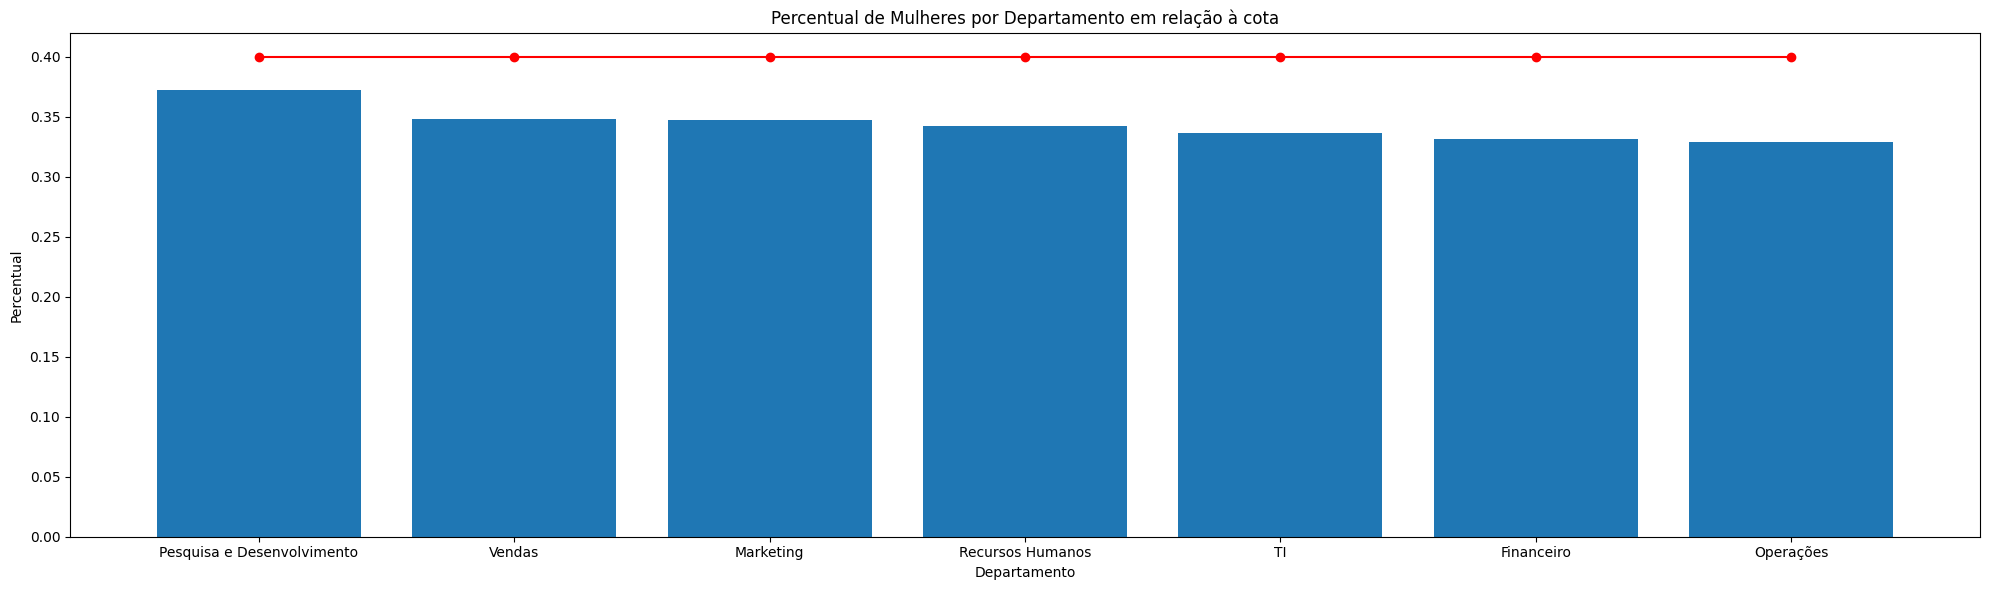

In [181]:
sub_dep_mulher = tabela_mulher.loc[tabela_mulher['Cargo']=='Subordinado'].copy()
sub_dep_mulher = sub_dep_mulher.sort_values('Diferença Percentual', ascending=True)

plt.figure(figsize=(20, 6))

# Barras (% de mulheres)
plt.bar(sub_dep_mulher["Departamento"], sub_dep_mulher["Mulher (%)"])

# Linha da cota
plt.plot(sub_dep_mulher["Departamento"], sub_dep_mulher["Cota Mulher (%)"], marker="o", color='red')

plt.xlabel("Departamento")
plt.ylabel("Percentual")
plt.title("Percentual de Mulheres por Departamento em relação à cota")

plt.tight_layout()
plt.show()

O gráfico acima mostra os departamentos, dos mais próximos aos mais distantes de atingir a cota estabelicida de mulheres. Desta forma o RH poderia decidir abrir vagas inclusivas nos departamentos que possuem menos representatividade feminina. A mesma lógica poderia ser aplicada às outras cotas.

#### Representatividade PPI na liderança da empresa

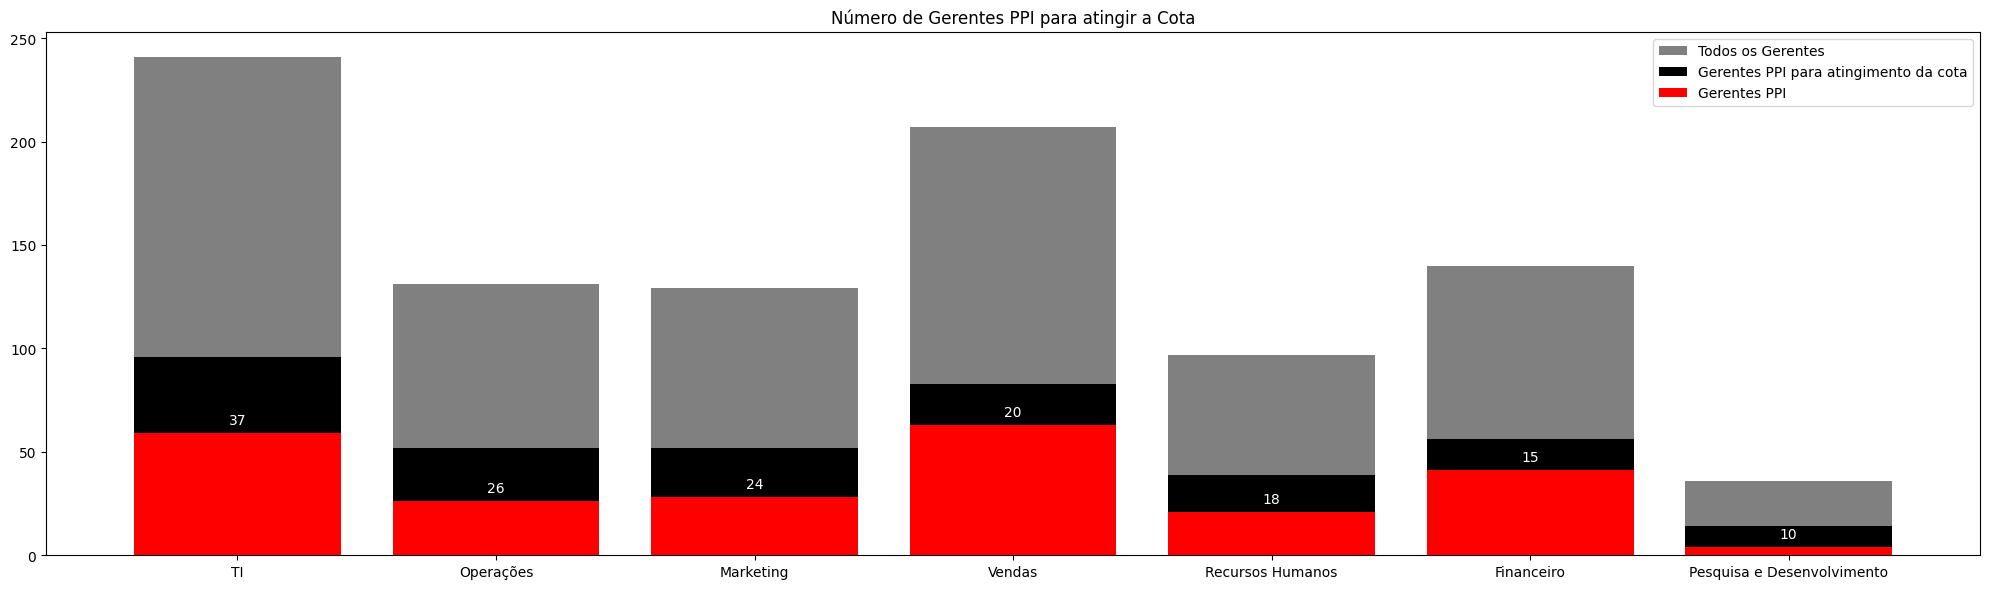

In [182]:
ger_dep_ppi = tabela_ppi.loc[tabela_ppi['Cargo']=='Gerente'].copy()
ger_dep_ppi = ger_dep_ppi.sort_values('Espaço de Contratação', ascending=False)

plt.figure(figsize=(20, 6))

# Barras (espaço de contratação)
plt.bar(ger_dep_ppi["Departamento"], ger_dep_ppi['total_pessoas'], color='gray', label = 'Todos os Gerentes') # Total de pessoas no departamento em cargo gerencial
plt.bar(ger_dep_ppi["Departamento"], ger_dep_ppi['Cota PPI (qtd)'], color='black', label = 'Gerentes PPI para atingimento da cota') # Total de pessoas PPI que faltaram para atingir a cota
plt.bar(ger_dep_ppi["Departamento"], ger_dep_ppi['Preta/Parda/Indígena'], color='red', label = 'Gerentes PPI') # Total de pessoas PPI no departamento em cargo gerencial

# Adicionar rótulos acima da barra vermelha
for i, (dep, ppi, esp) in enumerate(zip(
    ger_dep_ppi["Departamento"],
    ger_dep_ppi["Preta/Parda/Indígena"],
    ger_dep_ppi["Espaço de Contratação"]
)): plt.text(i, ppi + 3, f"{esp:.0f}", ha="center", va="bottom", color='white')


plt.title("Número de Gerentes PPI para atingir a Cota")
plt.legend()

plt.tight_layout()
plt.show()

O gráfico acima apresenta a janela de pessoas que faltou para bater a cota ppi de gerentes em cada departamento. Dessa forma, o RH tem uma visão clara de quais departamentos estão precisando mais de representatividade em liderança de pessoas PPI.

#### Índice de diversidade na gerência

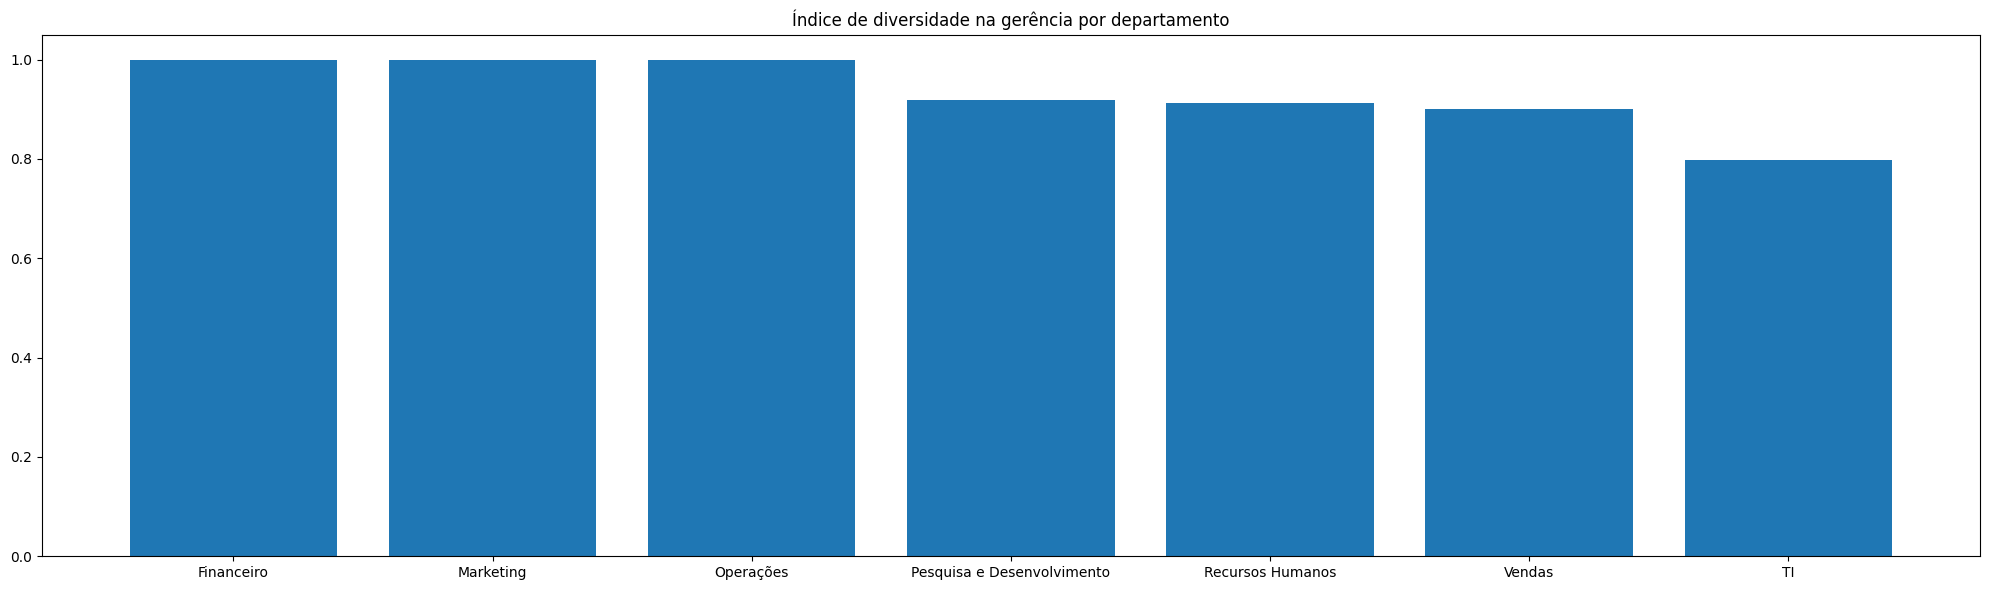

In [183]:
# Gráfico de Diversidade por Cargo e Departamento
ger_indice_div = diversidade_dep_cargo.loc[diversidade_dep_cargo['Cargo']=='Gerente'].copy()
ger_indice_div = ger_indice_div.sort_values('Índice de Diversidade', ascending = False)

plt.figure(figsize=(20,6))
plt.bar(ger_indice_div['Departamento'], ger_indice_div['Índice de Diversidade'])
plt.title("Índice de diversidade na gerência por departamento")
plt.tight_layout()
plt.show()

No gráfico acima é possível distinguir quais departamentos possuem mais ou menos grupos diversos dentro do quadro de gerentes.

#### Grau de escolaridade por etnia

In [184]:
tabela_grau_escolaridade = (
    dados_funcionarios
    .pivot_table(
        index=["Grau de escolaridade"],
        columns="Etnia Minoria",
        values="Id",
        aggfunc="count",
        fill_value=0
    )
    .reset_index()
)
tabela_grau_escolaridade

Etnia Minoria,Grau de escolaridade,Branca/Amarela,Não Declarada,Preta/Parda/Indígena
0,Fundamental Completo,1309,31,540
1,Médio Completo,2864,109,1096
2,Pós-Graduação/Especialização,832,26,242
3,Superior Completo,2463,46,442


In [185]:
ordem = {
    "Fundamental Completo": 1,
    "Médio Completo": 2,
    "Superior Completo": 3,
    "Pós-Graduação/Especialização": 4
}
tabela_grau_escolaridade['N Grau de escolaridade'] = tabela_grau_escolaridade['Grau de escolaridade'].map(ordem)

In [186]:
t_ba = tabela_grau_escolaridade['Branca/Amarela'].sum(axis=0)
tabela_grau_escolaridade['%_BA'] = round(tabela_grau_escolaridade['Branca/Amarela']/t_ba, 4)
t_ppi = tabela_grau_escolaridade['Preta/Parda/Indígena'].sum(axis=0)
tabela_grau_escolaridade['%_PPI'] = round(tabela_grau_escolaridade['Preta/Parda/Indígena']/t_ppi, 4)
tabela_grau_escolaridade = tabela_grau_escolaridade.sort_values('N Grau de escolaridade')

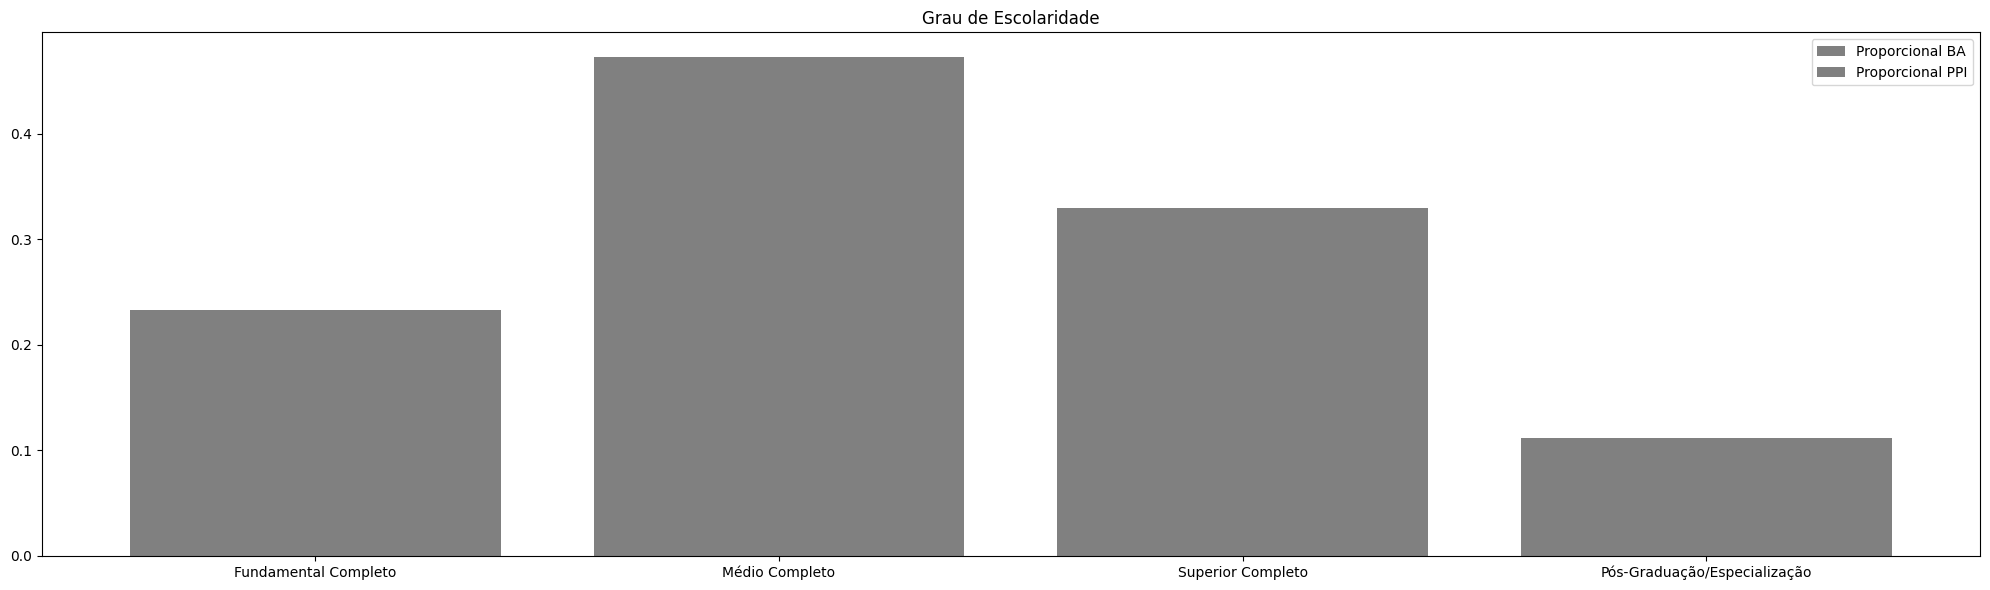

In [187]:
plt.figure(figsize=(20, 6))

# Barras (espaço de contratação)
plt.bar(tabela_grau_escolaridade["Grau de escolaridade"], tabela_grau_escolaridade['%_BA'], color='gray', label = 'Proporcional BA')
plt.bar(tabela_grau_escolaridade["Grau de escolaridade"], tabela_grau_escolaridade['%_PPI'], color='gray', label = 'Proporcional PPI')


plt.title("Grau de Escolaridade")
plt.legend()

plt.tight_layout()
plt.show()

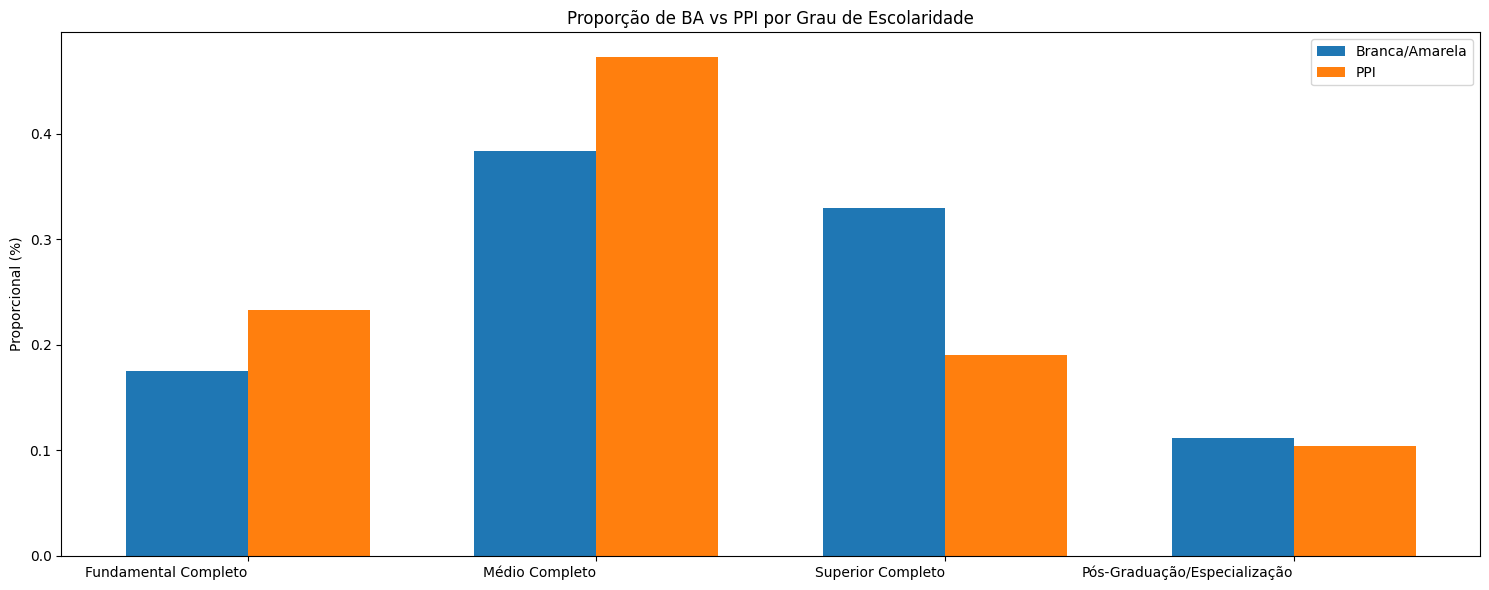

In [188]:
# posições das barras
x = np.arange(len(tabela_grau_escolaridade["Grau de escolaridade"]))
largura = 0.35  # largura das barras

plt.figure(figsize=(15, 6))

# Barras lado a lado
plt.bar(x - largura/2, tabela_grau_escolaridade['%_BA'], width=largura, label='Branca/Amarela')
plt.bar(x + largura/2, tabela_grau_escolaridade['%_PPI'], width=largura, label='PPI')

# Rótulos
plt.xticks(x, tabela_grau_escolaridade["Grau de escolaridade"], ha='right')
plt.ylabel("Proporcional (%)")
plt.title("Proporção de BA vs PPI por Grau de Escolaridade")
plt.legend()

plt.tight_layout()
plt.show()

O gráfico acima representa o quadro de funcionários em relação a proporção de pessoas por etnia em cada grau de escolaridade. É possível identificar que entre as pessoas ppi e ba, o mais comum é ter apenas o ensino médio completo, porém é visível a diferença de concentração. A maior parte dos funcionarios ppi tem formação inferior aos funcionários ba.